<a href="https://colab.research.google.com/github/afschowdhury/Pytorch_basic/blob/main/Intro-to-gan(Anime-Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'

od.download(dataset_url)

  2%|▏         | 7.00M/395M [00:00<00:05, 70.6MB/s]

100%|██████████| 395M/395M [00:03<00:00, 106MB/s] 


In [3]:
import os 
from image_info import Image_info 
import numpy as np


DATA_DIR = 'animefacedataset'
total_images_in_dataset = len(os.listdir(DATA_DIR+'/images'))
print("Total images : ",total_images_in_dataset)




ModuleNotFoundError: ignored

In [2]:
# getting a random image 

random_index = np.random.randint(0,total_images_in_dataset)
random_image_path = DATA_DIR+'/images/'+os.listdir(DATA_DIR+'/images')[random_index]

random_image = Image_info(random_image_path)
random_image.show_details()



NameError: ignored

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# making dataset and data loader with Data Augmentation and Normalization
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T


In [12]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5) 

In [14]:
train_ds = ImageFolder(DATA_DIR, T.Compose([T.Resize(image_size),
                                                 T.CenterCrop(image_size),
                                                 T.ToTensor(),
                                                 T.Normalize(*stats)]))
train_loader = DataLoader(train_ds, batch_size,shuffle=True, num_workers=4,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
#  helper functionto denormalize the normalized image ( for better visual only )
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


In [20]:
def denorm(img_tensors):
  return img_tensors*stats[1][0] +stats[0][0]   # for each channel , adding the mean and multiplying by std

def show_batch_images(dl, nmax = 64):
  for images, _ in dl:


    fig , ax = plt.subplots(figsize= (8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))
    break



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


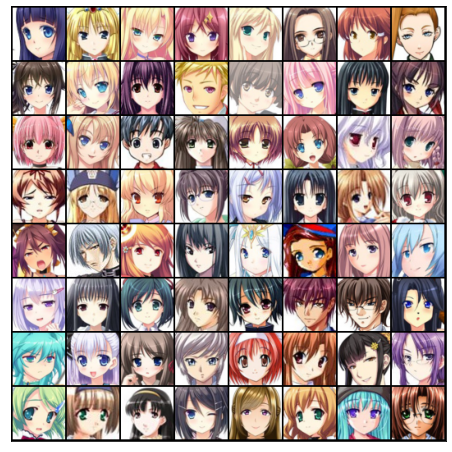

In [23]:
show_batch_images(train_loader)

## Using GPU

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [1]:
device = get_default_device()
device

NameError: ignored